<a href="https://colab.research.google.com/github/tiffahana/homework3introtoai/blob/main/Tarea_3_Intro_a_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 3: Redes Neuronales Convolucionales**

### Estudiante: Daniela Salinas

El objetivo de esta tarea es implementar una Red Neuronal Convolucional que logre clasificar los labels correspondientes a la base de datos de manuscritos MNIST y la base de datos de imágenes pequeñas CIFAR-10. La tarea debe ser realizada en Python usando TensorFlow.

In [1]:
"""Esta area configura el entorno Jupyter.
Por favor, no modifique nada en esta celda.
"""
import os
import sys
import time

# Importar módulos diversos
from IPython.core.display import display, HTML

In [2]:
import os
import numpy as np
import tensorflow as tf
import random
from unittest.mock import MagicMock


def _print_success_message():
    print('Pruebas superadas.')
    print('Puede pasar a la siguiente tarea.')

def test_normalize_images(function):
    test_numbers = np.array([0,127,255])
    OUT = function(test_numbers)
    test_shape = test_numbers.shape

    assert type(OUT).__module__ == np.__name__,\
        'Not Numpy Object'

    assert OUT.shape == test_shape,\
        'Incorrect Shape. {} shape found'.format(OUT.shape)
    np.testing.assert_almost_equal(test_numbers/255, OUT)

    _print_success_message()

def test_one_hot(function):
    test_numbers = np.arange(10)
    number_classes = 10
    OUT = function(test_numbers,number_classes)

    awns = np.identity(number_classes)
    test_shape = awns.shape

    assert type(OUT).__module__ == np.__name__,\
        'Not Numpy Object'

    assert OUT.shape == test_shape,\
        'Incorrect Shape. {} shape found'.format(OUT.shape)
    np.testing.assert_almost_equal(awns, OUT)

    _print_success_message()

# Convolutional Neural Networks

<div class="alert alert-warning">
En este notebook nos familiarizaremos con un tipo de *capa* para redes neuronales artificiales llamadas capas convolucionales. Los datos que intentaremos modelar utilizando este tipo de redes serán imágenes.
</div>


## Imágenes

Para un computador, una imagen es una matriz de datos en la que cada píxel está representado por uno o varios valores:


### Matriz con un valor por píxel = imágenes en escala de grises

<img src="https://www.researchgate.net/publication/330902210/figure/fig1/AS:878026619375622@1586349267376/mage-of-Abraham-Lincoln-as-a-matrix-of-pixel-values.ppm" alt="Grayscale Image" width="700">[image_source](http://openframeworks.cc/ofBook/chapters/image_processing_computer_vision.html)

### Matriz con tres valores por píxel = imágenes en color
 <img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/color_images.png" alt="Decomposition of a color image" width="400">[image_source](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)

# El Dataset MNIST

La base de datos MNIST (Modified National Institute of Standards and Technology database) es un problema de clasificación multiclase en el que se nos pide que clasifiquemos un dígito ($0-9$) a partir de una imagen en escala de grises de $28\times 28$:

>La base de datos MNIST de dígitos escritos a mano, disponible en esta página, tiene un conjunto de entrenamiento de 60.000 ejemplos y un conjunto de prueba de 10.000 ejemplos. Es un subconjunto de un conjunto más amplio disponible en NIST. Los dígitos han sido normalizados en tamaño y centrados en una imagen de tamaño fijo.

>Es una buena base de datos para las personas que quieren probar técnicas de aprendizaje y métodos de reconocimiento de patrones en datos del mundo real, dedicando un esfuerzo mínimo al preprocesamiento y al formateo.

[Fuente](https://www.tensorflow.org/datasets/catalog/mnist?hl=es-419)

En el siguiente ejemplo cargaremos datos de MNIST.

* **input** $\rightarrow$ 70000 muestras de vectores
    * Cada vector tiene 784 dimensiones
    * Aquí se presentan como matrices de $28\times 28$ $\rightarrow$ Imágenes en escala de grises
* **target** $\rightarrow$ 70000 enteros que indican un dígito de 0 a 9

<div class="alert alert-info">
<strong>En el siguiente fragmento de código:</strong>
<ul>
  <li>Cargaremos la base de datos MNIST</li>
  <li>Graficaremos la 5ª muestra del conjunto de entrenamiento</li>
</ul>
</div>

Shape of x_train (60000, 28, 28)
Shape of y_train (60000,)
Shape of x_test (60000, 28, 28)
Shape of y_test (60000,)


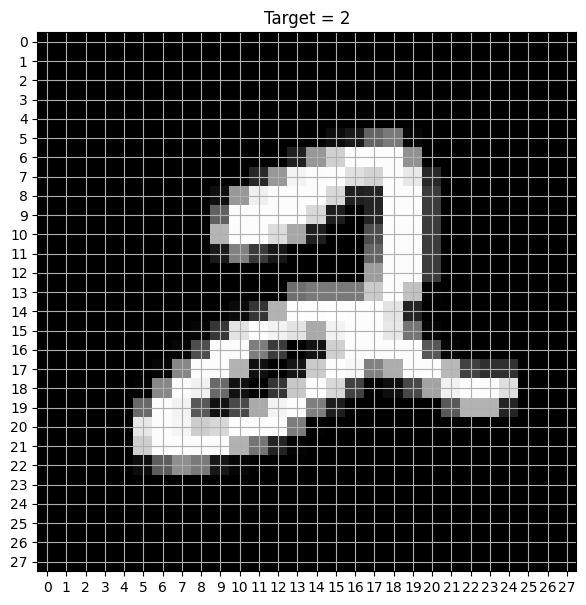

In [3]:
# Los gráficos se mostrarán dentro del Jupyter Notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time

# NumPy es un paquete para manipular objetos de matriz de N dimensiones
import numpy as np

# Pandas es un paquete de análisis de datos
import pandas as pd

# Mnist wrapper
from keras.datasets import mnist

# Código para cargar la base de datos MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Imprimir la dimensionalidad de los datos
print('Shape of x_train {}'.format(x_train.shape))
print('Shape of y_train {}'.format(y_train.shape))
print('Shape of x_test {}'.format(x_train.shape))
print('Shape of y_test {}'.format(y_train.shape))


# Código para graficar la 5ª muestra del conjunto de entrenamiento
fig,ax1 = plt.subplots(1,1, figsize=(7, 7))

ax1.imshow(x_train[5], cmap='gray')
title = 'Target = {}'.format(y_train[5])
ax1.set_title(title)
ax1.grid(which='Major')
ax1.xaxis.set_major_locator(MaxNLocator(28))
ax1.yaxis.set_major_locator(MaxNLocator(28))
fig.canvas.draw()
time.sleep(0.1)

## Preprocesamiento de datos

Antes de empezar a clasificar los dígitos, tenemos que preprocesar los datos.

La primera tarea es crear una función que normalice las imágenes de 8 bits de [0,255] a [0,1]:


### Parte I:  Implementar una Función de Normalización de Imágenes
<div class="alert alert-success">
**Tarea**: Implementar una función que normalice las imágenes al intervalo [0,1].
<ul>
  <li>Las entradas son números enteros en el intervalo [0,255]</li>
  <li>Las salidas deben ser flotantes en el intervalo [0,1]</li>
</ul>
</div>

In [4]:
def normalize_images(images):
    """Normalizar las imágenes de entrada.
    """
    # Normalizar la imagen dividiendo cada píxel por 255 y redondear
    images = images / 255.0
    images = np.round(images, decimals=7)

    return images

### *No* modificar las siguientes líneas ###
test_normalize_images(normalize_images)

# Normalizar los datos para su uso futuro
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

Pruebas superadas.
Puede pasar a la siguiente tarea.


### Parte II:  Ampliar la dimensión de la entrada

Cuando cargamos el conjunto de datos MNIST, cada dígito estaba representado por una matriz de tamaño $(28, 28)$. Sin embargo, la red neuronal artificial que vamos a construir utiliza el concepto de canales de color y mapas de características incluso para las imágenes en escala de grises. Esto significa que tenemos que transformar $(28, 28)$ en $(28, 28, 1)$.

<div class="alert alert-success">
**Tarea**: Escribir una pieza de código que añada una nueva dimensión a `x_train` y `x_test`.
<ul>
  <li>La dimensionalidad de `x_train` debe ser $(60000, 28, 28, 1)$</li>
  <li>La dimensionalidad de `x_test` debe ser $(10000, 28, 28, 1)$</li>
</ul>
    
Echa un vistazo en [numpy.expand_dims()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html) para saber cómo se puede hacer esto.   
</div>

In [5]:
# Escribe aquí tu código
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

### *No* modifique las siguientes lineas ###
print('Shape of x_train {}'.format(x_train.shape))
print('Shape of y_train {}'.format(y_train.shape))
print('Shape of x_test {}'.format(x_test.shape))
print('Shape of y_test {}'.format(y_test.shape))

Shape of x_train (60000, 28, 28, 1)
Shape of y_train (60000,)
Shape of x_test (10000, 28, 28, 1)
Shape of y_test (10000,)


## Preprocesamiento de los labels

Para clasificar nuestros dígitos tenemos que utilizar one-hot encoding para representar las salidas de los objetivos. One-hot encoding es una solución robusta y sencilla para representar objetivos multicategóricos.

Esta codificación es una representación ideal para entrenar un modelo mediante el algoritmo de descenso de gradiente con la [función softmax](http://www.cs.toronto.edu/~guerzhoy/321/lec/W04/onehot.pdf).

### Ejemplo de one-hot encoding

Este es un ejemplo de cómo es un esquema de one-hot encoding:

$$
\begin{equation*}
\mathbf{y} =
\left[ \begin{array}{c} 2 \\ 8 \\ 0 \\ 6 \\ \vdots\end{array} \right]
\Longrightarrow
\begin{bmatrix}
  0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
\end{bmatrix}
\end{equation*}
$$

En el lado izquierdo tenemos un vector de etiquetas objetivo $\mathbf{y}$ con $K=10$ número de clases. En el lado derecho podemos ver la versión codificada one-hot del vector $\mathbf{y}$ donde cada elemento $\in \mathbf{y}$ se ha transformado en un vector de filas $K$-dimensional. Sólo el elemento $\mathbf{y}_i$ se ha fijado en 1, el resto son 0. Por ejemplo, el primer elemento de $\mathbf{y}$ es 2, lo que significa que el vector codificado en un punto será todo ceros excepto la posición 2 (indexación 0). Del mismo modo, el tercer elemento de $\mathbf{y}$ es 0, lo que significa que el vector codificado one-hot será todos los ceros a excepción de la posición 0.

La idea central es transformar los datos multicategóricos en una combinación de varias clases simples. Al hacer esto podemos, para cada ejemplo, ver si pertenece a alguna clase, donde 1 indica que sí y 0 en caso contrario.


### Parte 3:  Implemente una función para One-Hot Encoding

<div class="alert alert-success">
**Tarea**: Implementar una función que codifique un vector de números en una matriz de $K$ clases:
<ul>
  <li>El primer argumento es un vector con $N$ muestras (dimensiones)</li>
  <li>El segundo argumento es un número $K$ que significa el número de clases</li>
  <li>Para cada muestra del vector se creará un array con $K$ dimensiones</li>
  <li>La matriz codificada one-hot debe tener ceros en todas las posiciones excepto en la posición indicada por la muestra actual en el vector de entrada</li>
</ul>
</div>

* Intenta implementar esta función por ti mismo. Si tienes dudas, pide ayuda
* Si te quedas sin tiempo, utiliza `keras.utils.to_categorical(vector, number_classes)`

In [6]:
def one_hot(vector, number_classes):
    """Devuelve una matriz codificada one-hot dado el vector argumento.
    """
    # Aquí almacenaremos nuestros one-hots
    one_hot = []

    # Aquí se codifica el 'vector' one-hot
    for i in vector:
      one_hot_item = np.zeros(number_classes)
      one_hot_item[i] = 1
      one_hot.append(one_hot_item)

    # Transformar la lista en una matriz numpy y retornarla
    return np.array(one_hot)


### *No* modifique las siguientes lineas ###
test_one_hot(one_hot)

# One-hot codifica los labels de MNIST
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

Pruebas superadas.
Puede pasar a la siguiente tarea.


Ahora que hemos añadido una dimensión adicional a los datos de entrada y que hemos codificado los valores objetivo como one-hot, vamos a ver las formas de las matrices de datos.

In [7]:
print('Shape of x_train {}'.format(x_train.shape))
print('Shape of y_train {}'.format(y_train.shape))
print('Shape of x_test {}'.format(x_train.shape))
print('Shape of y_test {}'.format(y_train.shape))

Shape of x_train (60000, 28, 28, 1)
Shape of y_train (60000, 10)
Shape of x_test (60000, 28, 28, 1)
Shape of y_test (60000, 10)


# Construir una Red Neuronal Artificial con Convoluciones y Max-Pooling


## Convoluciones

Si tienes un clasificador que consiste en reconocer gatos en una imagen, es posible que se quiera reconocer/clasificar al animal independientemente de su posición. Para ello, nos basamos en un hecho estadístico: las imágenes naturales son estacionarias [source](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Por lo tanto, si calculamos una estadística para algún lugar de la imagen de entrada, entonces esa estadística también podría ser valiosa para calcularla en algún otro lugar. Se puede aprovechar esta propiedad para definir pequeñas redes que aprendan características que puedan aplicarse a diferentes partes de una imagen.

Las redes neuronales convolucionales emplean estos aspectos para crear redes neuronales muy eficaces.

Si quiere ver un vídeo corto (con subtítulos) que explica los conceptos de las redes convolucionales, consulte el siguiente enlace de YouTube:

* [Udacity - Convolutional Networks](https://www.youtube.com/watch?v=jajksuQW4mc)

### Sliding windows (ventanas deslizantes)

Una ventana deslizante define una pequeña región de interés en una imagen.

La región de interés se utiliza para escanear toda la imagen, como se muestra en la siguiente animación:

<img src="https://pyimagesearch.com/wp-content/uploads/2014/10/sliding_window_example.gif" alt="Sliding window on a greyscale image" width="200">


Si utilizamos la ventana deslizante para definir cuál es la entrada que ve una pequeña red neuronal, tenemos la llamada convolución.


Suponiendo que tenemos una imagen en color, y una pequeña red neuronal con $k$ salidas: para cada posición posible de la ventana deslizante tendremos $k$ salidas.


<img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/conv.png" alt="Output of a convolution at for a given sliding window placement" width="300">


Una vez que la ventana deslizante ha escaneado toda la imagen, se obtiene una matriz tridimensional que puede investigarse más a fondo.


<img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/conv2.png" alt="Output of a convolution at for a given sliding window placement" width="300">

### Ejemplo de Convolución


Supongamos que tenemos una imagen de $5 \times 5=25$ píxeles:

$$
\begin{equation*}
\begin{array}{|c|c|c|c|c|}
  \hline
  1 & 1 & 1 & 0 & 0 \\
  \hline
  0 & 1 & 1 & 1 & 0\\
  \hline
  0 & 0 & 1 & 1 & 1\\
  \hline
  0 & 0 & 1 & 1 & 0\\
  \hline
  0 & 1 & 1 & 0 & 0\\
  \hline
\end{array}
\end{equation*}
$$

Supongamos que definimos una pequeña red neuronal que tiene pesos de $3 \times 3$ y una única salida.
La matriz de pesos es

$$
\begin{equation*}
\begin{array}{|c|c|c|}
  \hline
  1 & 0 & 1 \\
  \hline
  0 & 1 & 0\\
  \hline
  1 & 0 & 1\\
  \hline
\end{array}
\end{equation*}
$$

Al alimentar la red utilizando una ventana deslizante de $3 \times 3$ obtenemos las siguientes características convolucionadas (también conocidas como mapa de características):

$$
\begin{equation*}
\begin{array}{|c|c|c|}
  \hline
  4 & 3 & 4 \\
  \hline
  2 & 4 & 3\\
  \hline
  2 & 3 & 4\\
  \hline
\end{array}
\end{equation*}
$$


<img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/Convolution_schematic.gif" alt="Sliding window" width="500">

[source](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)

El número de los llamados *mapas de características* producidos dependerá del número de salidas de la red neuronal. En este caso sólo tenemos un mapa de características.


#### Stride y Padding

Podemos utilizar padding y strides para controlar el tamaño de los mapas de características. A continuación se presentan cuatro animaciones que muestran la operación de convolución en una matriz de entrada utilizando diferentes paddings y strides:

<table style="width:100%">
  <tr>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/6/6c/Convolution_arithmetic_-_No_padding_no_strides.gif" width="400"></td>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_arithmetic_-_No_padding_strides.gif" width="400"></td>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/e/ee/Convolution_arithmetic_-_Same_padding_no_strides.gif" width="400"></td>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif" width="400"></td>
  </tr>
  <tr>
    <td>$padding = 0\qquad stride = 1$</td>
    <td>$padding = 0\qquad stride = 2$</td>
    <td>$padding = 1\qquad stride = 1$</td>
    <td>$padding = 1\qquad stride = 2$</td>
  </tr>
</table>

[source](https://github.com/vdumoulin/conv_arithmetic), [paper](https://arxiv.org/abs/1603.07285)

En el caso de las imágenes, *padding* se traduce en el número de píxeles nuevos que introducimos alrededor del borde de una imagen, mientras que *stride* es la distancia a la que se desplaza el núcleo de convolución después de cada aplicación.

Terminología menor vista en ciertos tipos de literatura:

* **Padding válido** equivale a zero padding
* **Mismo padding** significa que el padding utilizado es una función del tamaño del kernel para que el tamaño de salida tenga el mismo tamaño que el de entrada


### Cálculo del tamaño de las convoluciones

Para calcular el tamaño del mapa de características resultante de una convolución necesitamos conocer el tamaño de la entrada, el tamaño del núcleo (filtro), el stride y el padding:

$$
\begin{equation*}
output = \frac{1}{stride} (input -  kernel + 2 * padding) + 1
\end{equation*}
$$

En el caso de las entradas bidimensionales, la altura y la anchura se pueden calcular así:

$$
\begin{equation*}
height_{new} =  \frac{1}{stride} (height_{input} - height_{kernel} + 2 * padding)+1
\end{equation*}
$$
<br class="math" />
$$
\begin{equation*}
widht_{new} =  \frac{1}{stride} (widht_{input} - widht_{kernel} + 2 * padding)+1
\end{equation*}
$$


#### Ejemplo :

Supongamos que tenemos una imagen de $6 \times 6$. Si rellenamos esta imagen con un solo píxel y luego la convolucionamos con un núcleo de $3 \times 3$ utilizando un stride de $2$, obtenemos el siguiente mapa de características (feature map) de $3 \times 3$:

<img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/odd.gif" alt="Examples math" width="300">

Podemos calcular el tamaño de salida utilizando las ecuaciones anteriores:

$$
\begin{equation*}
\begin{aligned}
height_{new} &= \frac{1}{stride} (height_{input} - height_{kernel} + 2 * padding) + 1 \\
&= \frac{1}{2} (6 - 3 + 2 * 1) + 1 \\
&= \frac{1}{2}(5)+1 \\
&= 3
\end{aligned}
\end{equation*}
$$
* Observe que redondeamos los números flotantes, por lo que pasamos de 3,5 a 3.

## Pooling

Se ha convertido en una práctica común el uso de la capa de pooling entre las capas convolucionales.

Las redes neuronales convolucionales exitosas como [alexnet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks), [VGG16, VGG19](https://arxiv.org/abs/1409.1556) emplean esta técnica.

Las capas de pooling también dependen de las ventanas deslizantes, pero en lugar de utilizar la ventana como entradas para las neuronas, los datos de entrada deslizantes pasan por un operador `max`, `mean` o algún otro.

### Un ejemplo de Max-Pooling

<img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/pooling.gif" alt="Max Pooling" width="300">

El max-pooling tiene varias ventajas:
* Si tiene imágenes en las que la misma clase tiene imágenes similares con pequeños desplazamientos en la posición de los píxeles, el max pooling mitigará las pequeñas traslaciones.
* Introduce zero parameters en el modelo, ya que los operadores de máxima y media son funciones fijas que no dependen de los pesos
* Reduce la cantidad de datos que hay que procesar en la siguiente capa, asegurando al mismo tiempo cierta invariabilidad de la traslación de los píxeles.
* Se utilizan normalmente con zero padding (también conocido padding válido).
* Siguen la misma matemática dimensional que las convoluciones

[Puede leer más sobre los operadores de pooling aquí](http://cs231n.github.io/convolutional-networks/#pool)

## Implementando una Red Convolucional

Implementaremos la siguiente CNN:

<img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/mnist_net.png" alt="CNN" width="1280">

Los componentes de esta red pueden verse a continuación:

Defina una entrada:

* `input_x = Input(shape=sample_shape)`
* `sample_shape` es un parámetro de entrada
    
Genere 32 kernel maps utilizando una capa convolucional:

* La convolución utiliza un kernel de $3 \times 3$, stride 1, zero padding, y una función de activación [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
* Utilice [Conv2D](https://keras.io/layers/convolutional/) desde la librería Keras
* `output_layer = Conv2D(PARAMETERS)(input_layer)`
    
Genere 64 kernel maps utilizando una capa convolucional:

* La convolución utiliza un kernel de $3 \times 3$, stride 1, zero padding, y una función de activación [ReLU]
* Utilice [Conv2D](https://keras.io/layers/convolutional/)
* `output_layer = Conv2D(PARAMETERS)(input_layer)`

Reduzca los feature maps utilizando max-pooling:

* La capa max-pooling debe utilizar un kernel de $2 \times 2$, stride `None`, y zero padding
* Utilice [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d)
* `output_layer = MaxPooling2D(PARAMETERS)(input_layer)`

Aplane el feature map:

* [Flatten](https://keras.io/layers/core/#flatten)

Capa fully-connected, i.e. `Dense`, a 128 dimensiones:

* Función de activación [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
* [Dense](https://keras.io/layers/core/#dense)

Capa fully-connected, i.e. `Dense`, a $K$ clases (argumento) dimensiones:

* Función de activación [Softmax](https://en.wikipedia.org/wiki/Softmax_function)
* [Dense](https://keras.io/layers/core/#dense)


### Parte IV:  Implemente una Convolutional Neural Network

Es hora de implementar nuestra primera red neuronal convolucional.

<div class="alert alert-success">
<strong>Tarea:</strong> Cree una función `net_1()` que implemente la red especificada anteriormente.
</div>

In [8]:
# Importar la librería Keras
import keras
from keras.models import Model
from keras.layers import *


def net_1(sample_shape, nb_classes):
    # Defina la entrada de la red para que tenga la dimensión `sample_shape
    input_x = Input(shape=sample_shape)

    # Cree aquí las conexiones internas de la red
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(input_x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    x = Flatten()(x)
    probabilities = Dense(nb_classes, activation='softmax')(x)

    # Defina la salida
    model = Model(inputs=input_x, outputs=probabilities)

    return model

<div class="alert alert-info">
  <strong>En el siguiente fragmento de código</strong>
<ul>
  <li>Crearemos una red utilizando la función que acabas de implementar</li>
  <li>Mostrar un resumen de la red</li>
</ul>
</div>

In [9]:
# Dimensión de la muestra
sample_shape = x_train[0].shape

# Construir una red
model = net_1(sample_shape, 10)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 10)                125450    
                                                             

### Parte V: Definir los Hiperparámetros y entrenar la red

Tenemos que definir los hiperparámetros para que nuestra red pueda aprender.

<div class="alert alert-success">

<strong>Tarea:</strong> Afina los hiperparámetros hasta que su `loss` y `val_loss` converjan a números bajos:
   
<ul>
  <li>Tamaño de batch</li>
  <li>Número de épocas de entrenamiento</li>
</ul>
</div>


Epoch 1/20
53/53 - 11s - loss: 2.2981 - accuracy: 0.1416 - val_loss: 2.2943 - val_accuracy: 0.1515 - 11s/epoch - 209ms/step
Epoch 2/20
53/53 - 2s - loss: 2.2929 - accuracy: 0.1541 - val_loss: 2.2888 - val_accuracy: 0.1670 - 2s/epoch - 42ms/step
Epoch 3/20
53/53 - 2s - loss: 2.2876 - accuracy: 0.1677 - val_loss: 2.2831 - val_accuracy: 0.1853 - 2s/epoch - 42ms/step
Epoch 4/20
53/53 - 2s - loss: 2.2821 - accuracy: 0.1851 - val_loss: 2.2772 - val_accuracy: 0.2033 - 2s/epoch - 42ms/step
Epoch 5/20
53/53 - 2s - loss: 2.2763 - accuracy: 0.2046 - val_loss: 2.2710 - val_accuracy: 0.2235 - 2s/epoch - 43ms/step
Epoch 6/20
53/53 - 2s - loss: 2.2703 - accuracy: 0.2274 - val_loss: 2.2646 - val_accuracy: 0.2505 - 2s/epoch - 44ms/step
Epoch 7/20
53/53 - 2s - loss: 2.2640 - accuracy: 0.2503 - val_loss: 2.2578 - val_accuracy: 0.2763 - 2s/epoch - 43ms/step
Epoch 8/20
53/53 - 2s - loss: 2.2574 - accuracy: 0.2737 - val_loss: 2.2507 - val_accuracy: 0.3005 - 2s/epoch - 43ms/step
Epoch 9/20
53/53 - 2s - loss:

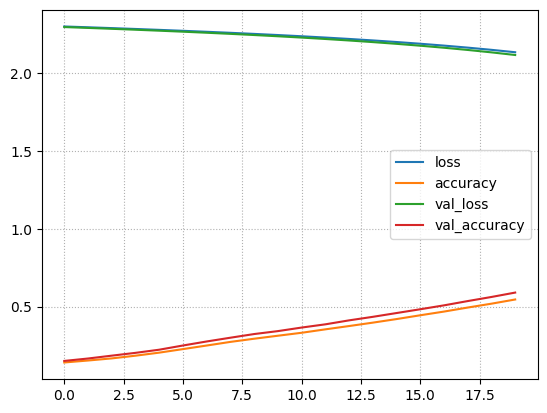

Assesing Test dataset...
Test loss: 2.1219139099121094
Test accuracy: 0.5666999816894531


In [10]:
# Defina los hiperparámetros
# Se probó con 32, 64, 128, 256, 512, 1024, 2048, 4096, 8912 y 16384
# Pudimos notar que existe una mejoría mínima mientras mayor tamaño es el batch, no obstante, más lento
# Concluyo que el mejor valor es 1024
batch_size = 1024
epochs = 20

### *No* modifique las siguientes líneas ###

# No hay tasa de aprendizaje porque estamos usando los valores recomendados
# para el optimizador Adadelta. Más información aquí:
# https://keras.io/optimizers/

# Necesitamos compilar nuestro modelo
model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

# Entrenar
logs = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=2,
                 validation_split=0.1)

# Graficar losses y el accuracy
fig, ax = plt.subplots(1,1)

pd.DataFrame(logs.history).plot(ax=ax)
ax.grid(linestyle='dotted')
ax.legend()

plt.show()

# Evaluar el rendimiento
print('='*80)
print('Assesing Test dataset...')
print('='*80)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## ¿Deberíamos usar Max-Pooling?

Recientemente se ha discutido si max-pooling es una buena solución para reducir la cantidad de datos entre capas de una red. Algunos enfoques recientes muestran que se puede conseguir un rendimiento similar, y a veces mejor, utilizando convoluciones con strides mayores que 1.


> Deshacerse de pooling. A mucha gente no le gusta la operación de pooling y cree que se puede prescindir de ella. Por ejemplo, [Striving for Simplicity: The All Convolutional Net](http://arxiv.org/abs/1412.6806) propone descartar la capa de pooling en favor de una arquitectura que sólo conste de capas CONV repetidas. Para reducir el tamaño de la representación, sugieren utilizar un stride mayor en la capa CONV de vez en cuando. También se ha descubierto que descartar las capas de pooling es importante para entrenar buenos modelos generativos, como los autoencoders variacionales (VAE) o las redes generativas adversariales (GAN). Parece probable que las arquitecturas futuras tengan muy pocas o ninguna capa de pooling.

[source](http://cs231n.github.io/convolutional-networks/#pool)


### Parte VI: Implemente una Convolutional Network sin Max-Pooling

Implemente una Convolutional Neural Network sin capas de pooling:

<img src="https://raw.githubusercontent.com/vicolab/neural-network-intro/master/3-convnet/resources/mnist_net2.png" alt="CNN" width="1280">

<div class="alert alert-success">
<strong>Tarea:</strong> Replique la red que construimos anteriormente (`net_1()`), pero esta vez:
<ul>
  <li>Remueva la capa de max pooling y añada un stride=2 al segundo bloque de convolución.
  </li>
</ul>
</div>

Observación: vea [Conv2D](https://keras.io/layers/convolutional/)
      


In [11]:
def net_2(sample_shape, nb_classes):
    # Defina la entrada de la red para que tenga la dimensión `sample_shape
    input_x = Input(shape=sample_shape)

    # Cree aquí las conexiones internas de la red
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(input_x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Flatten()(x)
    probabilities = Dense(nb_classes, activation='softmax')(x)

    # Defina la salida
    model = Model(inputs=input_x, outputs=probabilities)

    return model

<div class="alert alert-info">
  <strong>En el siguiente fragmento de códigol:</strong>
<ul>
  <li>Crearemos una red utilizando la función que acabamos de implementar</li>
  <li>Mostraremos un resumen de la red</li>
</ul>
</div>

In [12]:
# Dimensión de la muestra
sample_shape = x_train[0].shape

# Construir una red
model = net_2(sample_shape, 10)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                125450    
                                                                 
Total params: 144266 (563.54 KB)
Trainable params: 144266 (563.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Parte VII: Definir los Hiperparámetros y Entrenar la Red Neuronal

Como antes, necesitamos definir algunos hiperparámetros y entrenar la red. Siéntase libre de reutilizar los hiperparámetros que encontró antes.

<div class="alert alert-success">
<strong>Tarea:</strong> Afinar los siguientes hiperparámetros hasta que `loss` y `val_loss` converjan en números bajos:
<ul>
  <li>Tamaño de batch</li>
  <li>Número de epocas de entrenamiento</li>
</ul>
</div>

Epoch 1/20
53/53 - 3s - loss: 2.3025 - accuracy: 0.1450 - val_loss: 2.3014 - val_accuracy: 0.1547 - 3s/epoch - 54ms/step
Epoch 2/20
53/53 - 1s - loss: 2.2999 - accuracy: 0.1570 - val_loss: 2.2986 - val_accuracy: 0.1673 - 1s/epoch - 25ms/step
Epoch 3/20
53/53 - 1s - loss: 2.2972 - accuracy: 0.1709 - val_loss: 2.2957 - val_accuracy: 0.1803 - 1s/epoch - 25ms/step
Epoch 4/20
53/53 - 1s - loss: 2.2944 - accuracy: 0.1884 - val_loss: 2.2928 - val_accuracy: 0.2017 - 1s/epoch - 25ms/step
Epoch 5/20
53/53 - 1s - loss: 2.2915 - accuracy: 0.2101 - val_loss: 2.2897 - val_accuracy: 0.2270 - 1s/epoch - 26ms/step
Epoch 6/20
53/53 - 1s - loss: 2.2885 - accuracy: 0.2356 - val_loss: 2.2865 - val_accuracy: 0.2543 - 1s/epoch - 26ms/step
Epoch 7/20
53/53 - 1s - loss: 2.2854 - accuracy: 0.2635 - val_loss: 2.2832 - val_accuracy: 0.2862 - 1s/epoch - 25ms/step
Epoch 8/20
53/53 - 1s - loss: 2.2822 - accuracy: 0.2930 - val_loss: 2.2798 - val_accuracy: 0.3158 - 1s/epoch - 25ms/step
Epoch 9/20
53/53 - 1s - loss: 2.

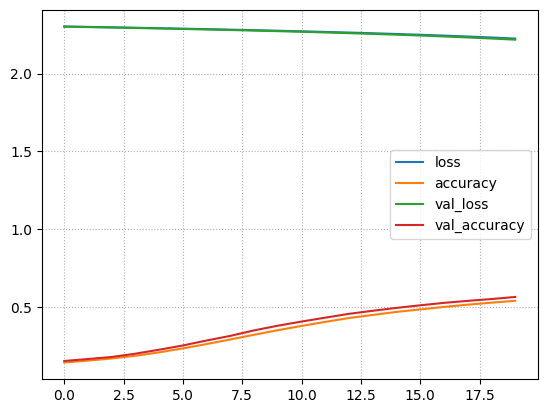

In [13]:
# Defina los hiperparámetros
batch_size = 1024
epochs = 20

### *No* modifique las siguientes líneas ###

# Necesitamos compilar nuestro modelo
model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

# Entrenar
logs = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split = 0.1,)

# Graficar losses y el accuracy
fig, ax = plt.subplots(1,1)

pd.DataFrame(logs.history).plot(ax=ax)
ax.grid(linestyle='dotted')
ax.legend()
fig.canvas.draw()


# Evaluar el rendimiento
print('='*80)
print('Assesing Test dataset...')
print('='*80)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# CIFAR

La siguiente explicación de Cifar 10 proviene de [official cifar page](https://www.cs.toronto.edu/~kriz/cifar.html):

CIFAR-10 y CIFAR-100 son subconjuntos etiquetados del dataset compuesto por <a href="http://people.csail.mit.edu/torralba/tinyimages/">80 millones de imágenes pequeñas</a>. Fueron recolectados por Alex Krizhevsky, Vinod Nair y Geoffrey Hinton.


## CIFAR10 Dataset

El dataset CIFAR-10 consta de 60000 imágenes en color de $32 \times 32$, compuesta por 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de prueba.

El dataset se divide en cinco batches de entrenamiento y un batch de prueba, cada uno con 10000 imágenes. El batch de prueba contiene exactamente 1000 imágenes seleccionadas al azar de cada clase. Los batches de entrenamiento contienen el resto de imágenes en orden aleatorio, pero algunos batches de entrenamiento pueden contener más imágenes de una clase que de otra. Entre ellos, los batches de entrenamiento contienen exactamente 5000 imágenes de cada clase.

Aquí están las clases del dataset, así como 10 imágenes aleatorias de cada una:
<table>
    <tr>
        <td class="cifar-class-name">airplane</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">automobile</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">bird</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">cat</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">deer</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">dog</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">frog</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">horse</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">ship</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship10.png" class="cifar-sample" /></td>
    </tr>
    <tr>
        <td class="cifar-class-name">truck</td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck1.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck2.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck3.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck4.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck5.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck6.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck7.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck8.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck9.png" class="cifar-sample" /></td>
        <td><img src="https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck10.png" class="cifar-sample" /></td>
    </tr>
</table>

Las clases son completamente excluyentes. No hay solapamiento entre los automóviles y los camiones. "Automóvil" incluye sedans, todoterrenos y cosas de ese tipo. "Camión" incluye sólo los camiones grandes. Tampoco incluye las camionetas.

En el siguiente ejemplo cargaremos los datos de CIFAR10.

* **input** $\rightarrow$ 60000 muestras de 3072 vectores dimensionales.
    * Aquí se presentan como matrices de $32 \times 32 \times 3$  $\rightarrow$ Imágenes de color
* **target** $\rightarrow$ 60000 escalares que indican una clase de 0 a 9

<div class="alert alert-info">
  <strong>En el siguiente código:</strong>
<ul>
  <li>Cargaremos el dataset CIFAR10</li>
  <li>Graficaremos la 5ª muestra del conjunto de entrenamiento</li>
</ul>
</div>

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Shape of x_train (50000, 32, 32, 3)
Shape of y_train (50000, 1)
Shape of x_test (50000, 32, 32, 3)
Shape of y_test (50000, 1)


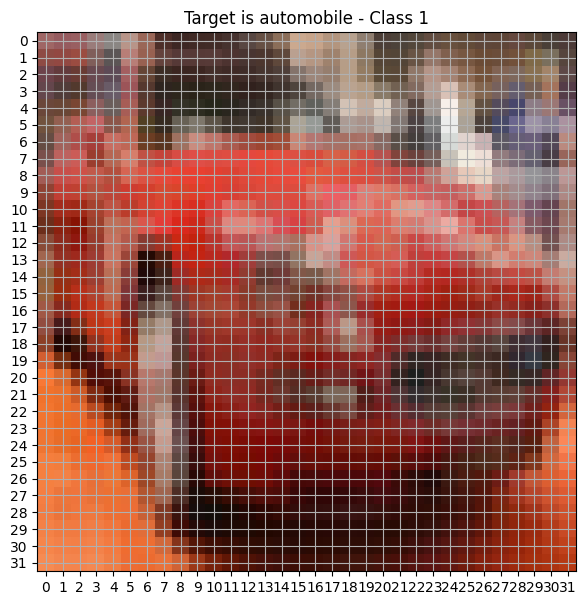

In [19]:
from keras.datasets import cifar10

# Los datos divididos entre los conjuntos de entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

target_2_class = {0:'airplane',
                  1:'automobile',
                  2:'bird',
                  3:'cat',
                  4:'deer',
                  5:'dog',
                  6:'frog',
                  7:'horse',
                  8:'ship',
                  9:'truck'}

# Código para graficar la 5ª muestra de entrenamiento.
fig,ax1 = plt.subplots(1,1, figsize=(7,7))
ax1.imshow(x_train[5])
target = y_train[5][0]
title = 'Target is {} - Class {}'.format(target_2_class[target],target )
ax1.set_title(title)
ax1.grid(which='Major')
ax1.xaxis.set_major_locator(MaxNLocator(32))
ax1.yaxis.set_major_locator(MaxNLocator(32))
fig.canvas.draw()
time.sleep(0.1)

print('Shape of x_train {}'.format(x_train.shape))
print('Shape of y_train {}'.format(y_train.shape))
print('Shape of x_test {}'.format(x_train.shape))
print('Shape of y_test {}'.format(y_train.shape))

### Parte VIII: Codificación One-Hot para los Labels

<div class="alert alert-success">
<strong>Tarea:</strong> Utilice la función `one_hot()` que creó anteriormente para codificar:
<ul>
  <li>`y_test`</li>
  <li>`y_train`</li>
</ul>
</div>

In [20]:
y_test = one_hot(y_test, 10)
y_train = one_hot(y_train, 10)

### *No* modifique las siguientes líneas ###
# Imprima los tamaños de los datos (variables)
print('Shape of x_train {}'.format(x_train.shape))
print('Shape of y_train {}'.format(y_train.shape))
print('Shape of x_test {}'.format(x_train.shape))
print('Shape of y_test {}'.format(y_train.shape))

Shape of x_train (50000, 32, 32, 3)
Shape of y_train (50000, 10)
Shape of x_test (50000, 32, 32, 3)
Shape of y_test (50000, 10)


### Parte IX: Normalizar las imágenes

<div class="alert alert-success">
<strong>Tarea:</strong> Utilice la función `normalize_images()` que creó anteriormente para normalizar las imágenes en:
<ul>
  <li>`x_test`</li>
  <li>`x_train`</li>
</ul>
</div>

In [21]:
x_test = normalize_images(x_test)
x_train = normalize_images(x_train)

### Parte X: Cree su CNN para CIFAR10

<div class="alert alert-success">
  <strong>Tarea:</strong> Cree un modelo de red neuronal para entrenar CIFAR usando lo que hemos aprendido hasta ahora.
<ul>
  <li>Cree una nueva red utilizando `net_1()` o `net_2()`</li>
  <li>Mostrar un resumen de la red</li>.
  <li>Compilar el modelo utilizando `Adadelta`, `Adagrad`, o `Adam` como su optimizador</li>
</ul>
Parte del código ya está rellenado, así que modifique lo que necesite.
</div>

In [22]:
# Dimensionalidad de la muestra
sample_shape = x_train[0].shape

# Construcción de la red
model = net_1(sample_shape, 10)
model.summary()

# Necesitamos compilar nuestro modelo de red neuronal
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)             (None, 10)                163850    
                                                           

### Parte XI: Entrene su modelo

<div class="alert alert-success">
  <strong>Tarea:</strong> : Entrenar el modelo creado en la celda anterior en CIFAR10.
  <ul>
  <li>Entrene la red utilizando `epochs = 30`</li>
  <li>Entrene la red utilizando un `batch_size = 128`</li>
  <li>Utilice `validation_split = 0.2` cuando llame a `fit()`</li>
  <li>Planifica las pérdidas y la precisión</li>
  <li>Evaluar el rendimiento en el conjunto de pruebas</li>.
</ul>
Le recomendamos que no copie y pegue de las celdas anteriores, sino que reescriba el código usted mismo. Siempre puedes echar un vistazo a las celdas anteriores si no estás seguro de lo que debes hacer.
</div>

Epoch 1/30
313/313 - 5s - loss: 1.8506 - accuracy: 0.3737 - val_loss: 1.8568 - val_accuracy: 0.3644 - 5s/epoch - 15ms/step
Epoch 2/30
313/313 - 3s - loss: 1.8469 - accuracy: 0.3754 - val_loss: 1.8533 - val_accuracy: 0.3655 - 3s/epoch - 9ms/step
Epoch 3/30
313/313 - 3s - loss: 1.8434 - accuracy: 0.3756 - val_loss: 1.8504 - val_accuracy: 0.3652 - 3s/epoch - 10ms/step
Epoch 4/30
313/313 - 3s - loss: 1.8399 - accuracy: 0.3771 - val_loss: 1.8471 - val_accuracy: 0.3689 - 3s/epoch - 10ms/step
Epoch 5/30
313/313 - 3s - loss: 1.8364 - accuracy: 0.3794 - val_loss: 1.8436 - val_accuracy: 0.3682 - 3s/epoch - 9ms/step
Epoch 6/30
313/313 - 3s - loss: 1.8331 - accuracy: 0.3798 - val_loss: 1.8406 - val_accuracy: 0.3694 - 3s/epoch - 9ms/step
Epoch 7/30
313/313 - 3s - loss: 1.8298 - accuracy: 0.3803 - val_loss: 1.8374 - val_accuracy: 0.3710 - 3s/epoch - 11ms/step
Epoch 8/30
313/313 - 3s - loss: 1.8265 - accuracy: 0.3822 - val_loss: 1.8344 - val_accuracy: 0.3708 - 3s/epoch - 9ms/step
Epoch 9/30
313/313 -

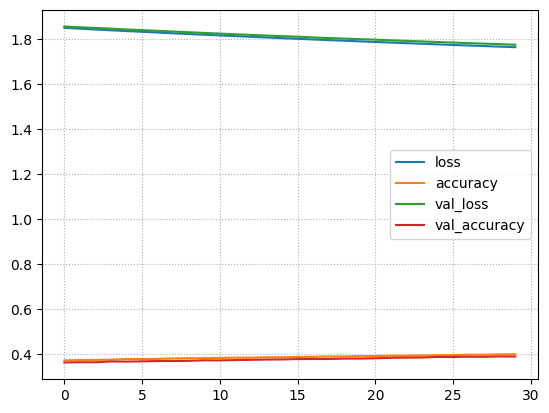

In [32]:
# Defina los hiperparámetros
batch_size = 128
epochs = 30

### *No* modifique las siguientes líneas ###

# Necesitamos compilar nuestro modelo
model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

# Entrenar
logs = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split = 0.2,)

# Graficar losses y el accuracy
fig, ax = plt.subplots(1,1)

pd.DataFrame(logs.history).plot(ax=ax)
ax.grid(linestyle='dotted')
ax.legend()
fig.canvas.draw()


# Evaluar el rendimiento
print('='*80)
print('Assesing Test dataset...')
print('='*80)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Temas de reflexión

* ¿Qué modelo funciona mejor?
* ¿Qué optimizador funciona mejor?
* ¿Existe alguna evidencia de overfitting?
* ¿Cómo podemos mejorar aún más el rendimiento?

1-El modelo que funciona mejor en esta oportunidad es aquel que realiza el max-pooling, es decir, la red neuronal convolucional que hemos llamado como la función "net_1()", ya que, se obtiene una mejor precisión y una menor cantidad de pérdida

2-El optimizador que usamos en esta investigación fue el de "Adadelta", la cual, es una extensión del algoritmo "Adagrad", tal algoritmo está basado en adaptar la tasa de aprendizaje para las variables teniendo en cuenta el gradiente acumulado en cada una de ellas, de forma que a aquellas que acumulan un gradiente acumulado mayor se les aplica una tasa de aprendizaje menor y viceversa, la diferencia es que "Adadelta" resuelve las limitaciones del algoritmo "Adagrad".

3-Es importante recordar que para verificar overfitting y en nuestro caso con un gráfico y valores de pérdida, debemos notar si la pérdida en el conjunto de validación comienza a aumentar mientras en el conjunto de entrenamiento sigue disminuyendo. Respecto a la red neuronal convolucional con max-pooling o también conocida en esta investigación como "net_1()" no existe el overfitting durante las 20 épocas, pues, la pérdida del conjunto de validación disminuye constantemente. Por otro lado, la red neuronal convolucional sin max-pooling o también conocida en esta investigación como "net_2()" tampoco se ve índices de overfitting durante las 20 épocas, la pérdida del conjunto de validación también disminuye constantemente. Por lo tanto, podemos concluir que en 20 épocas en ambas redes neuronales convolucionales no existe el overfitting.

4-Para mejorar el rendimiento en ambas redes realizamos el ajuste de hiperparámetros probando con diferente valores, realizamos preprocesamiento de los datos, también utilizamos un optimizador, reducción de dimensionalidad y aplicamos técnicas de regularización. No obstante, podríamos mejorar el rendimiento quizás adaptando mejor la arquitectura de la red neuronal convolucional, probar con más capas o cambiar el número de unidades de estas capas, cambiar la función de activación, entre otros. Como también podríamos mejorar el rendimiento realizando un análisis de errores para verificar posibles fallas y posibles optimizaciones.